# Economic Dispatch

_**[Power Systems Optimization](https://github.com/east-winds/power-systems-optimization)**_

_by Michael R. Davidson and Jesse D. Jenkins (last updated: October 4, 2022)_

This notebook will introduce a key operational model&mdash;economic dispatch (ED)&mdash;which minimizes the short-run production costs of meeting electricity demand from a given set of generators subject to various technical constraints.

We build up the model in several stages. We begin with a single-time period and simple generator constraints just related to allowable output ranges. This allows us to compare the model with the intuition provided by the merit order supply curve (also known as the "dispatch stack"). 

We then add multiple time periods by considering the economic dispatch over an entire day. Due to the simple generator constraints, this simple model does not introduce any coupling across time.

More realism is added by considering engineering constraints that introduce time coupling&mdash;namely, ramp rates, which are an important limitation of many generators.

Finally, we examine the famous "duck curve" by adding more solar onto the system and explore the role that ramp rates play in the solution.

## Introduction to economic dispatch

Every day, system operators need to decide how to meet demand from a large variety of generators with different costs and engineering requirements. Prior to large-scale computational capabilities, this was accomplished by "priority lists" or similar heuristics to determine the ordering of plants. However, with modern optimization algorithms, operators can find the global minimum of production costs&mdash;and even incorporate coupling of engineering processes across time periods.

**Economic dispatch** (ED) is the problem of minimizing short-run costs of production in order to meet a given demand, considering relevant engineering constraints of the generators. It *does not* fully capture the physics of electricity flows, which will further constrain the feasible space and which we will come back to in later notebooks on optimal power flow, nor does it account for decisions and constraints related to turning on or "committing" large thermal generators, which we'll discuss in our next notebook on unit commitment. Typically, *it does* incorporate some type of network representation, which we have ignored here by considering only a single bus. More on the networks in the notebook on optimal power flow.

## Single-time period, simple generator constraints

We will first examine the case where we are optimizing dispatch for a single snapshot in time, with only very simple constraints on the generators.
    
$$
\begin{align}
\min \ & \sum_{g \in G} VarCost_g \times GEN_g & \\
\text{s.t.} & \\
 & \sum_{g} GEN_g = Demand & \\
 & GEN_g \leq Pmax_g & \forall \quad g \in G \\
 & GEN_g \geq Pmin_g & \forall \quad g \in G \\
\end{align}
$$

The **decision variable** in the above problem is:

- $GEN_{g}$, the generation (in MW) produced by each generator, $g$

The **parameters** are:

- $Pmin_g$, the minimum operating bounds for the generator (based on engineering or natural resource constraints)
- $Pmax_g$, the maximum operating bounds for the generator (based on engineering or natural resource constraints)
- $Demand$, the demand (in MW)

(For this simple problem, we will let $Pmin_g=0$ and revisit this later in the unit commitment notebook.)

In addition, we have:

$$
VarCost_g = VarOM_g + HeatRate_g \times FuelCost_g
$$

Note that, in contrast with the basic capacity expansion problem, we are not concerned with fixed costs. Why not?

The simplest response is that these costs have already been incurred and regardless of how much a generator produces, its fixed costs will not change. These costs are thus "[sunk costs](https://en.wikipedia.org/wiki/Sunk_cost)" and are constant in the objective function. Our optimal decision variables would not change by adjusting this constant up or down.

Therefore, we can safely ignore fixed costs for the purposes of finding optimal dispatch. (We will still have to consider them to calculate producer profits, however.)

[A famous electricity regulator](https://en.wikipedia.org/wiki/Ignacio_J._P%C3%A9rez_Arriaga), noting that it is frequently misunderstood and ignored even by experienced market participants, has called the application of the "[sunk cost fallacy](https://en.wikipedia.org/wiki/Sunk_cost#Fallacy_effect)" to electricity systems "[Grandma's Inheritance Theorem](http://link.springer.com/content/pdf/bbm%3A978-1-4471-5034-3%2F1.pdf)." In this hypothetical scenario, if you were to inherit a diamond ring or perhaps a financial contract-for-differences that pays out relative to cleared market prices (you have a very sophisticated grandma in this scenario!), you should not be tempted to change your production strategy.

Now, let's implement ED.

### 1. Load packages

In [1]:
# New packages introduced in this tutorial (run this if you need to install these)
import Pkg; Pkg.add("PrettyTables"); Pkg.add("VegaLite"); Pkg.add("FileIO")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [2]:
using JuMP, HiGHS
using Plots; plotly();
using VegaLite  # to make some nice plots
using DataFrames, CSV, PrettyTables
using FileIO
ENV["COLUMNS"]=120; # Set so all columns of DataFrames and Matrices are displayed

┌ Info: For saving to png with the Plotly backend PlotlyBase and PlotlyKaleido need to be installed.
└ @ Plots /Users/jdj2/.julia/packages/Plots/W75kY/src/backends.jl:319


### 2. Load and format data

We will use data based on San Diego Gas and Electric (SDG&E, via the [PowerGenome](https://github.com/gschivley/PowerGenome) data platform) plus a few neighboring generators, consisting of:

- 25 generators (including some clustering of smaller generators, and excluding behind-the-meter solar)
- estimated hourly demand for 2020 (net load at the transmission substation level after subtracting 600MW of behind-the-meter solar from original demand)
- variable generation capacity factors
- estimated natural gas fuel costs

In [3]:
datadir = joinpath("ed_data") 
# Note: joinpath is a good way to create path reference that is agnostic
# to what file system you are using (e.g. whether directories are denoted 
# with a forward or backwards slash).
gen_info = CSV.read(joinpath(datadir,"Generators_data.csv"), DataFrame);
fuels = CSV.read(joinpath(datadir,"Fuels_data.csv"), DataFrame);
loads = CSV.read(joinpath(datadir,"Demand.csv"), DataFrame);
gen_variable = CSV.read(joinpath(datadir,"Generators_variability.csv"), DataFrame);

# Rename all columns to lowercase (by convention)
for f in [gen_info, fuels, loads, gen_variable]
    rename!(f,lowercase.(names(f)))
end

**Construct generator dataframe**

In [4]:
# Keep only the columns relevant to our ED model 
# (We'll come back to other columns in our unit commitment notebooks)
select!(gen_info, 1:26, :stor) 
gen_df = outerjoin(gen_info,  fuels, on = :fuel) # load in fuel costs and add to data frame
rename!(gen_df, :cost_per_mmbtu => :fuel_cost)   # rename column for fuel cost
gen_df[ismissing.(gen_df[:,:fuel_cost]), :fuel_cost] .= 0

# create "is_variable" column to indicate if this is a variable generation source (e.g. wind, solar)
# Note: Julia's strict vectorization syntax requires us to create a new variable using the '!' indexing operator
# and the '.=' broadcasting assignment. See: https://julia.guide/broadcasting
gen_df[!, :is_variable] .= false
gen_df[in(["onshore_wind_turbine","small_hydroelectric","solar_photovoltaic"]).(gen_df.resource),
    :is_variable] .= true;

# create full name of generator (including geographic location and cluster number)
#  for use with variable generation dataframe
gen_df.gen_full = lowercase.(gen_df.region .* "_" .* gen_df.resource .* "_" .* string.(gen_df.cluster) .* ".0");

# remove generators with no capacity (e.g. new build options that we'd use if this was capacity expansion problem)
gen_df = gen_df[gen_df.existing_cap_mw .> 0,:];


### Long and wide data format example

In [5]:
df = gen_df[1:5,1:5]

,r_id,resource,region,existing_cap_mw,num_units
,Int64?,String?,String15?,Float64?,Int64?
1,1,biomass,WEC_SDGE,21.4,20
2,2,hydroelectric_pumped_storage,WEC_SDGE,42.0,2
3,3,natural_gas_fired_combined_cycle,WEC_SDGE,607.1,1
4,4,natural_gas_fired_combined_cycle,WEC_SDGE,30.0,1
5,5,natural_gas_fired_combined_cycle,WEC_SDGE,49.4,1


In [6]:
df = copy(gen_df)
select!(df, 1:5)
df = df[1:5,:]

,r_id,resource,region,existing_cap_mw,num_units
,Int64?,String?,String15?,Float64?,Int64?
1,1,biomass,WEC_SDGE,21.4,20
2,2,hydroelectric_pumped_storage,WEC_SDGE,42.0,2
3,3,natural_gas_fired_combined_cycle,WEC_SDGE,607.1,1
4,4,natural_gas_fired_combined_cycle,WEC_SDGE,30.0,1
5,5,natural_gas_fired_combined_cycle,WEC_SDGE,49.4,1


In [7]:
stack(df, 
    [:existing_cap_mw, :num_units], 
    variable_name=:var,
    value_name=:val)

,r_id,resource,region,var,val
,Int64?,String?,String15?,String,Float64?
1,1,biomass,WEC_SDGE,existing_cap_mw,21.4
2,2,hydroelectric_pumped_storage,WEC_SDGE,existing_cap_mw,42.0
3,3,natural_gas_fired_combined_cycle,WEC_SDGE,existing_cap_mw,607.1
4,4,natural_gas_fired_combined_cycle,WEC_SDGE,existing_cap_mw,30.0
5,5,natural_gas_fired_combined_cycle,WEC_SDGE,existing_cap_mw,49.4
6,1,biomass,WEC_SDGE,num_units,20.0
7,2,hydroelectric_pumped_storage,WEC_SDGE,num_units,2.0
8,3,natural_gas_fired_combined_cycle,WEC_SDGE,num_units,1.0
9,4,natural_gas_fired_combined_cycle,WEC_SDGE,num_units,1.0


**Modify load and variable generation dataframes**

1. Convert from GMT to GMT-8

The load and variable generation files are in GMT. We want to convert to local California time. Here, we will ignore daylight savings and simply subtract 8 hours. (A more proper solution would involve the use of the [TimeZones](https://github.com/JuliaTime/TimeZones.jl/) package.)

To accomplish this, we 'wrap' the last 8 hours of the data series (i.e., the last 8 hours of the year) around to the front of the series.

In [8]:
gen_variable.hour = mod.(gen_variable.hour .- 9, 8760) .+ 1 
sort!(gen_variable, :hour)
loads.hour = mod.(loads.hour .- 9, 8760) .+ 1
sort!(loads, :hour);

2. Convert from "wide" to "long" format:

The file is in "wide" format, which has separate columns for values from different types of generators. This has more human readability, but often we want to have it in "long" format for computation.

"Long" format refers to a dataframe with a separate row entry for every value. The rest of the columns are "indexes" that uniquely identify the row. In Julia, we use the DataFrame package's [`stack`](https://juliadata.github.io/DataFrames.jl/stable/man/reshaping_and_pivoting/) function to accomplish this. (This is similar to the [`melt`](https://www.rdocumentation.org/packages/reshape2/versions/1.4.4/topics/melt) function for those familiar with DataFrames in R)

In [9]:
describe(gen_variable)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Real,Float64,Real,Int64,DataType
1,hour,4380.5,1,4380.5,8760,0,Int64
2,wec_sdge_biomass_1.0,1.0,1,1.0,1,0,Int64
3,wec_sdge_hydroelectric_pumped_storage_1.0,1.0,1,1.0,1,0,Int64
4,wec_sdge_natural_gas_fired_combined_cycle_1.0,1.0,1,1.0,1,0,Int64
5,wec_sdge_natural_gas_fired_combined_cycle_2.0,1.0,1,1.0,1,0,Int64
6,wec_sdge_natural_gas_fired_combined_cycle_3.0,1.0,1,1.0,1,0,Int64
7,wec_sdge_natural_gas_fired_combined_cycle_4.0,1.0,1,1.0,1,0,Int64
8,wec_sdge_natural_gas_fired_combustion_turbine_1.0,1.0,1,1.0,1,0,Int64
9,wec_sdge_natural_gas_fired_combustion_turbine_2.0,1.0,1,1.0,1,0,Int64


In [10]:
gen_variable_long = stack(gen_variable, 
                        Not(:hour), 
                        variable_name=:gen_full,
                        value_name=:cf);
# Now we have a "long" dataframe; 
# let's look at the first 6 entries of a wind resource for example
first(gen_variable_long[gen_variable_long.gen_full.=="wec_sdge_onshore_wind_turbine_1.0",:],6)

,hour,gen_full,cf
,Int64,String,Float64
1,1,wec_sdge_onshore_wind_turbine_1.0,0.1694
2,2,wec_sdge_onshore_wind_turbine_1.0,0.1658
3,3,wec_sdge_onshore_wind_turbine_1.0,0.1502
4,4,wec_sdge_onshore_wind_turbine_1.0,0.1455
5,5,wec_sdge_onshore_wind_turbine_1.0,0.0932
6,6,wec_sdge_onshore_wind_turbine_1.0,0.0717


**Extract single time from the data**
(we will get to the full set later)

- demand
- variable generation

Note: variable generation profiles are often encoded in terms of hourly maximum capacity factor, expressed as a per unit value or percentage of installed capacity. Hourly capacity factor is then later multiplied by installed capacity to yield a maximum hourly generation for each resource.

In [11]:
hr = 2416  # pick 4pm on a spring day
loads_single = loads[loads[:,:hour] .== hr, Not(:hour)];
var_cf_single = gen_variable_long[
    gen_variable_long.hour .== hr, 
    Not(:hour)]

,gen_full,cf
,String,Float64
1,wec_sdge_biomass_1.0,1.0
2,wec_sdge_hydroelectric_pumped_storage_1.0,1.0
3,wec_sdge_natural_gas_fired_combined_cycle_1.0,1.0
4,wec_sdge_natural_gas_fired_combined_cycle_2.0,1.0
5,wec_sdge_natural_gas_fired_combined_cycle_3.0,1.0
6,wec_sdge_natural_gas_fired_combined_cycle_4.0,1.0
7,wec_sdge_natural_gas_fired_combustion_turbine_1.0,1.0
8,wec_sdge_natural_gas_fired_combustion_turbine_2.0,1.0
9,wec_sdge_natural_gas_fired_combustion_turbine_3.0,1.0


### 3. Create solver function

Here, we introduce a functionalized version of the optimization problem. We pass the problem parameters to the function, and it constructs and solves the model, returning the result. This will be useful when we wish to call the same basic model multiple times, e.g. for conducting sensitivities on parameters (among other things).

In [12]:
#=
Function to solve economic dispatch problem (single-time period, single-zone)
Inputs:
    gen_df -- dataframe with generator info
    loads  -- dataframe with load info
    gen_variable -- capacity factors of variable generators (in "long" format)
Note: it is always a good idea to include a comment blog describing your
function's inputs clearly!
=#
function economic_dispatch_single(gen_df, loads, gen_variable)
    ED = Model(HiGHS.Optimizer) # You could use Clp as well, with Clp.Optimizer
    
    # Define sets based on data
      # A set of all variable generators
    G_var = gen_df[gen_df[!,:is_variable] .== 1,:r_id] 
      # A set of all non-variable generators
    G_nonvar = gen_df[gen_df[!,:is_variable] .== 0,:r_id]
      # Set of all generators
    G = gen_df.r_id
    # Extract some parameters given the input data
      # Generator capacity factor time series for variable generators
    gen_var_cf = innerjoin(gen_variable, 
                    gen_df[gen_df.is_variable .== 1 , 
                        [:r_id, :gen_full, :existing_cap_mw]], 
                    on = :gen_full)
        
    # Decision variables   
    @variables(ED, begin
        GEN[G]  >= 0     # generation
        # Note: we assume Pmin = 0 for all resources for simplicty here
    end)
                
    # Objective function
    @objective(ED, Min, 
        sum( (gen_df[i,:heat_rate_mmbtu_per_mwh] * gen_df[i,:fuel_cost] +
            gen_df[i,:var_om_cost_per_mwh]) * GEN[i] 
                        for i in G_nonvar) + 
        sum(gen_df[i,:var_om_cost_per_mwh] * GEN[i] 
                        for i in G_var)
    )

    # Demand constraint
    @constraint(ED, cDemand, 
        sum(GEN[i] for i in G) == loads[1,:demand])

    # Capacity constraint (non-variable generation)
    for i in G_nonvar
        @constraint(ED, GEN[i] <= gen_df[i,:existing_cap_mw])
    end

    # Variable generation capacity constraint
    for i in 1:nrow(gen_var_cf)
        @constraint(ED, GEN[gen_var_cf[i,:r_id] ] <= 
                        gen_var_cf[i,:cf] *
                        gen_var_cf[i,:existing_cap_mw])
    end

    # Solve statement (! indicates runs in place)
    optimize!(ED)

    # Dataframe of optimal decision variables
    solution = DataFrame(
        r_id = gen_df.r_id,
        resource = gen_df.resource,
        gen = value.(GEN).data
        )

    # Return the solution and objective as named tuple
    return (
        solution = solution, 
        cost = objective_value(ED),
    )
end

economic_dispatch_single (generic function with 1 method)

### 4. Solve and print data

In [13]:
solution = economic_dispatch_single(gen_df, loads_single, var_cf_single);
solution.solution

Presolving model
1 rows, 25 cols, 25 nonzeros
1 rows, 22 cols, 22 nonzeros
Presolve : Reductions: rows 1(-25); columns 22(-3); elements 22(-28)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 1(2482) 0s
          1     5.8477778205e+04 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 1
Objective value     :  5.8477778205e+04
HiGHS run time      :          0.00


,r_id,resource,gen
,Int64?,String?,Float64
1,1,biomass,21.4
2,2,hydroelectric_pumped_storage,42.0
3,3,natural_gas_fired_combined_cycle,607.1
4,4,natural_gas_fired_combined_cycle,30.0
5,5,natural_gas_fired_combined_cycle,49.4
6,6,natural_gas_fired_combined_cycle,570.0
7,7,natural_gas_fired_combined_cycle,336.0
8,8,natural_gas_fired_combined_cycle,336.0
9,9,natural_gas_fired_combustion_turbine,0.0


We will now plot the **supply curve** (also known as the **dispatch stack**) for this single period to illustrate the concept of **merit order**. First, let's create a dataframe with the variable cost as a column, and then sort on it from lowest to highest.

In [16]:
supply_curve = leftjoin(gen_df,
                var_cf_single, 
                on = :gen_full)
supply_curve[!, :varcost] .= 0.0
supply_curve[!, :cap] .= 0.0

# Store varcost of non-variable generators:
I = supply_curve[!,:is_variable] .== 0  # `I` contains indexes to the non-variable generators
supply_curve[I,:varcost] .= 
    supply_curve[I,:heat_rate_mmbtu_per_mwh] .* 
        supply_curve[I,:fuel_cost] .+
    supply_curve[I,:var_om_cost_per_mwh]

# Calculate available capacity for each generator
supply_curve[I,:cap] = supply_curve[I,:existing_cap_mw]

# Store varcost of variable generators (in this case, 0)
I = (supply_curve[:,:is_variable] .== 1) # `I` contains indexes to the variable generators
supply_curve[I,:varcost] = supply_curve[I,:var_om_cost_per_mwh]

# Calculate available capacity for each generator
# (adjusted for variable generation)
supply_curve[I,:cap] = supply_curve[I,:existing_cap_mw] .* supply_curve[I,:cf]

sort!(supply_curve, :varcost);

Now, let's plot this as a supply curve where:

- width = capacity of the generator (i.e., $Pmax$)
- height = variable cost of the generator ($VarCost$)

In [17]:
rectangle(w, h, x, y) = Shape(x .+ [0,w,w,0], y .+ [0,0,h,h])

p = plot(nrow(supply_curve))

marg_gen = 0
marg_price = 0
x = 0
for i in 1:nrow(supply_curve)
    plot!(p, rectangle(supply_curve[i,:cap],
            supply_curve[i,:varcost],x,0), opacity=.5, 
            label = "")
    if (x < loads_single[1,:demand]) && (x + supply_curve[i,:cap] > loads_single[1,:demand])
        marg_gen = i
        marg_price = supply_curve[i,:varcost]
    end
    x = x + supply_curve[i,:cap]
end 
vline!([loads_single[1,:demand]],linecolor="black",linewidth=5,
label = "demand")
hline!([marg_price],linecolor="blue",linewidth=5,
label = "SRMC")
title!("Supply and demand curves")
xlabel!("Capacity")
ylabel!("Marginal cost")
p

In the above, everything to the left of demand is dispatched at full capacity, except for the last generator (the "marginal generator") where demand stops. Everything to the right is not dispatched (=0). We stored the marginal generator in `marg_gen`:

In [ ]:
supply_curve[marg_gen,:]

Which is generating $GEN_{marg\_gen}=$

In [ ]:
solution.solution[solution.solution.r_id .== supply_curve[marg_gen,:r_id],
    :gen][1]

**Combine by generation type**

We are often interested in the total generation *by type*, not individual generators. We use `combine` and `groupby` methods to sum over resource:

In [20]:
sol_gen = combine(groupby(solution.solution, :resource), 
            :gen => sum)
# We use the PrettyTable package here to round numbers when displaying
pretty_table(sol_gen, formatters = ft_printf("%5.3f")) 

┌──────────────────────────────────────┬──────────┐
│                             resource │  gen_sum │
│                              String? │  Float64 │
├──────────────────────────────────────┼──────────┤
│                              biomass │   21.400 │
│         hydroelectric_pumped_storage │   42.000 │
│     natural_gas_fired_combined_cycle │ 1928.500 │
│ natural_gas_fired_combustion_turbine │  136.755 │
│                 onshore_wind_turbine │   65.411 │
│                  small_hydroelectric │    3.185 │
│                   solar_photovoltaic │  284.750 │
└──────────────────────────────────────┴──────────┘


Finally, let's add back the 600MW of behind-the-meter solar to get a full picture of all the electricity on the grid.

In [21]:
# we use the copy function to create a copy of the dataframe (as opposed to working with the original)
sol_gen_btm = copy(sol_gen)

# We'll use the same variability profile for BTM solar as the utility-scale solar here (in reality, they would probably differ)
btm = DataFrame(resource = ["solar_photovoltaic_btm"], gen_sum = var_cf_single[var_cf_single.gen_full .== "wec_sdge_solar_photovoltaic_1.0",:cf] * 600)
append!(sol_gen_btm, btm)
pretty_table(sol_gen_btm, formatters = ft_printf("%5.3f")) # We use the PrettyTable package to round numbers when displaying

┌──────────────────────────────────────┬──────────┐
│                             resource │  gen_sum │
│                              String? │  Float64 │
├──────────────────────────────────────┼──────────┤
│                              biomass │   21.400 │
│         hydroelectric_pumped_storage │   42.000 │
│     natural_gas_fired_combined_cycle │ 1928.500 │
│ natural_gas_fired_combustion_turbine │  136.755 │
│                 onshore_wind_turbine │   65.411 │
│                  small_hydroelectric │    3.185 │
│                   solar_photovoltaic │  284.750 │
│               solar_photovoltaic_btm │  341.700 │
└──────────────────────────────────────┴──────────┘


Hence, the majority of energy is being met by combined cycle natural gas turbines (CCGT), second by solar PV, and third by behind-the-meter solar.

## Multiple-time period, simple generator constraints

We neglected the time dimension above and now we will add it back in. The key changes to the model arise from adding an additional index for time:

$$
\begin{align}
\min \ & \sum_{g \in G, t \in T} VarCost_g \times GEN_{g,t} & \\
\text{s.t.} & \\
 & \sum_{g} GEN_{g,t} = Demand_t & \forall \quad t \in T \\
 & GEN_{g,t} \leq Pmax_{g,t} & \forall \quad g \in G , t \in T \\
 & GEN_{g,t} \geq Pmin_{g,t} & \forall \quad g \in G , t \in T
\end{align}
$$


Note that for conventional generators, we often have $Pmax_{g,t} = Pmax_{g}$ and $Pmin_{g,t} = Pmin_{g}$ constant over time. (We will consider unit commitment later, which will alter this logic.)

For variable renewable generators, it is natural that $Pmax_{g,t}$ varies with time (i.e., based on solar irradiation or wind speeds). $Pmin_{g,t}$ for wind and solar resources is usually 0, but for hydropower resources, minimum streamflow constraints can produce a time-variant parameter.

### 3. Create solver function

(We reuse steps 1 and 2 above to load packages and data.)

In [22]:
#=
Function to solve economic dispatch problem (multi-time period, single-zone)
Inputs:
    gen_df -- dataframe with generator info
    loads  -- load by time
    gen_variable -- capacity factors of variable generators (in "long" format)
=#
function economic_dispatch_multi(gen_df, loads, gen_variable)
    ED = Model(HiGHS.Optimizer)

    # Define sets based on data
    G_var = gen_df[gen_df[!,:is_variable] .== 1,:r_id] 
    G_nonvar = gen_df[gen_df[!,:is_variable] .== 0,:r_id]
    G = gen_df.r_id
    T = loads.hour

    # Generator capacity factor time series for variable generators
    gen_var_cf = innerjoin(gen_variable, 
                    gen_df[gen_df.is_variable .== 1 , 
                        [:r_id, :gen_full, :existing_cap_mw]], 
                    on = :gen_full)
        
    # Decision variables   
    @variables(ED, begin
        GEN[G, T]  >= 0     # generation
        # Note: we assume Pmin = 0 for all resources for simplicty here
    end)
                
    # Objective function
    @objective(ED, Min, 
        sum( (gen_df[gen_df.r_id .== i,:heat_rate_mmbtu_per_mwh][1] * gen_df[gen_df.r_id .== i,:fuel_cost][1] +
            gen_df[gen_df.r_id .== i,:var_om_cost_per_mwh][1]) * GEN[i,t] 
                        for i in G_nonvar for t in T) + 
        sum(gen_df[gen_df.r_id .== i,:var_om_cost_per_mwh][1] * GEN[i,t] 
                        for i in G_var for t in T)
    )
    
    # Demand constraint
    @constraint(ED, cDemand[t in T], 
        sum(GEN[i,t] for i in G) == loads[loads.hour .== t,:demand][1])

    # Capacity constraints (non-variable generation)
    @constraint(ED, Cap_nonvar[i in G_nonvar, t in T], 
        GEN[i,t] <= gen_df[gen_df.r_id .== i,:existing_cap_mw][1])

    # Variable generation capacity constraints
    @constraint(ED, Cap_var[i in 1:nrow(gen_var_cf)], 
            GEN[gen_var_cf[i,:r_id], gen_var_cf[i,:hour] ] <= 
                        gen_var_cf[i,:cf] *
                        gen_var_cf[i,:existing_cap_mw])
    
    # Solve statement (! indicates runs in place)
    optimize!(ED)

    # Dataframe of optimal decision variables
    # This requires a few extra steps because we are indexing decision variables over two sets: generator and time
    solution = DataFrame(value.(GEN).data, :auto)  # :auto argument asks DataFrames to pick the variable names automatically
    ax1 = value.(GEN).axes[1]
    ax2 = value.(GEN).axes[2]
    cols = names(solution)
    insertcols!(solution, 1, :r_id => ax1)
    solution = stack(solution, Not(:r_id), variable_name=:hour)
    solution.hour = foldl(replace, [cols[i] => ax2[i] for i in 1:length(ax2)], init=solution.hour)
    rename!(solution, :value => :gen)
    solution.hour = convert.(Int64,solution.hour)
    
    # Return the solution and objective as named tuple
    return (
        solution = solution, 
        cost = objective_value(ED),
        status = termination_status(ED)
    )

end

economic_dispatch_multi (generic function with 1 method)

### 4. Solve a day's economic dispatch

We will subset our year-long dataset to a single spring day and solve.

In [23]:
n=100
T_period = (n*24+1):((n+1)*24)

loads_multi = loads[in.(loads.hour,Ref(T_period)),:]
gen_variable_multi = gen_variable_long[in.(gen_variable_long.hour,Ref(T_period)),:]

gen_df_sens = copy(gen_df)
gen_df_sens[gen_df_sens.resource .== "solar_photovoltaic",
    :existing_cap_mw] .= 3500

solution = economic_dispatch_multi(gen_df_sens, loads_multi, gen_variable_multi);

Presolving model
24 rows, 583 cols, 583 nonzeros
24 rows, 522 cols, 522 nonzeros
Presolve : Reductions: rows 24(-600); columns 522(-78); elements 522(-678)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     2.5048085200e+04 Pr: 24(53556.1) 0s
         24     8.0339333085e+05 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 24
Objective value     :  8.0339333085e+05
HiGHS run time      :          0.00


In [24]:
# **Add back in BTM solar and plot results**

sol_gen = innerjoin(solution.solution, 
                    gen_df[!, [:r_id, :resource]], 
                    on = :r_id)
sol_gen = combine(groupby(sol_gen, [:resource, :hour]), 
            :gen => sum)
sol_gen_btm = copy(sol_gen)
sol_gen_btm[sol_gen_btm.resource .== "solar_photovoltaic", :resource] .= "_solar_photovoltaic"
sol_gen_btm[sol_gen_btm.resource .== "onshore_wind_turbine", :resource] .= "_onshore_wind_turbine"
sol_gen_btm[sol_gen_btm.resource .== "small_hydroelectric", :resource] .= "_small_hydroelectric"

btm = DataFrame(resource = repeat(["_solar_photovoltaic_btm"]; outer=length(T_period)), 
    hour = T_period,
    gen_sum = gen_variable_multi[gen_variable_multi.gen_full .== "wec_sdge_solar_photovoltaic_1.0",:cf] * 600)
append!(sol_gen_btm, btm)

# Reorder resources
sort!(sol_gen_btm, [:hour, :resource])

#Write output
  # Create a 'results' directory in your current working directory if one does not yet exist
if !isdir("results") 
    mkdir("results")
end
  # Write the outputs to this folder
CSV.write("results/sol_gen_btm.csv",sol_gen_btm)

sol_gen_sum = combine(groupby(sol_gen_btm, [:resource]), 
            :gen_sum => sum)

,resource,gen_sum_sum
,String?,Float64
1,_onshore_wind_turbine,2314.42
2,_small_hydroelectric,76.4384
3,_solar_photovoltaic,20546.0
4,_solar_photovoltaic_btm,3522.18
5,biomass,513.6
6,hydroelectric_pumped_storage,1008.0
7,natural_gas_fired_combined_cycle,29749.6
8,natural_gas_fired_combustion_turbine,1224.89


**Plot charts**

We use the [VegaLite](https://www.queryverse.org/VegaLite.jl/stable/) library to make some fancier plots.

We also introduce the pipe operator `|>`, a helpful syntax that "pipes" the data on the left into the first argument of the function on the right. (Some more examples are [here](https://syl1.gitbook.io/julia-language-a-concise-tutorial/useful-packages/pipe).)

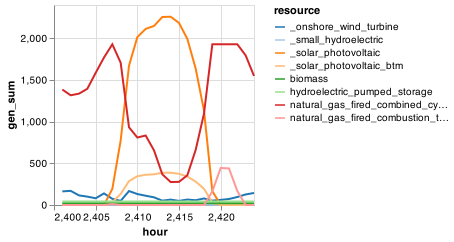

In [25]:
# Plot hourly generation by each resource type
sol_gen_btm |>
@vlplot(:line, 
    x=:hour, y=:gen_sum, 
    color={"resource:n", scale={scheme="category20"}})

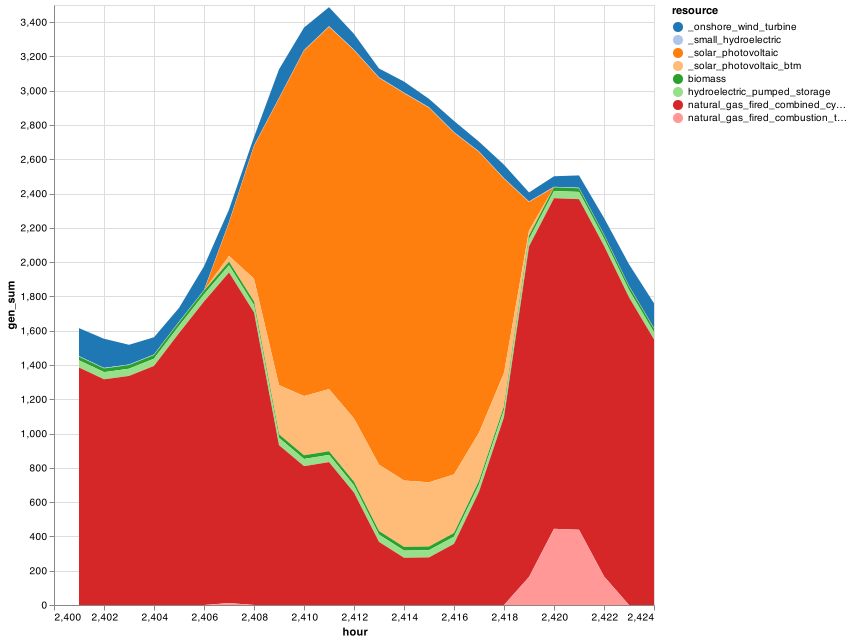

In [26]:
# Plot stacked generation by each resource type
g = sol_gen_btm |>
@vlplot(:area, 
    x=:hour, y={:gen_sum, stack=:zero}, 
    color={"resource:n", scale={scheme="category20"}},
    width=600,height=600)

In [ ]:
# Save this plot to file if you want to
g |> FileIO.save("results/ED_multitime.png")

For reference, here is the load shape (after subtracting BTM solar) we are trying solve:

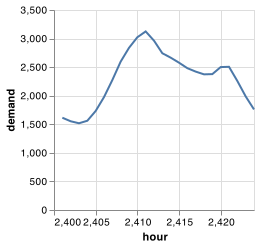

In [27]:
loads_multi |>
@vlplot(:line, 
    x=:hour, y=:demand)

## Multiple-time period, complex generator constraints with time coupling

The above problem did not include more than one time index per constraint. Hence, we could actually solve this each time period separately without regard to what is happening before or after. (These are known as "separable" problems.)

We now introduce time coupling into the model, by considering ramp rates, which limit how much generators can change output from one period to the next (an engineering constraint).

The new model:

$$
\begin{align}
\min \ & \sum_{g \in G, t \in T} VarCost_g \times GEN_{g,t} & \\
\text{s.t.} & \\
 & \sum_{g} GEN_{g,t} = Demand_t & \forall \quad t \in T \\
 & GEN_{g,t} \leq Pmax_{g,t} & \forall \quad g \in G , t \in T \\
 & GEN_{g,t} \geq Pmin_{g,t} & \forall \quad g \in G , t \in T \\
 & GEN_{g,t+1} - GEN_{g,t} \leq RampUp_{g} & \forall \quad g \in G , t = 1..T-1 \\
  & GEN_{g,t} - GEN_{g,t+1} \leq RampDn_{g} & \forall \quad g \in G , t = 1..T-1
\end{align}
$$



### 3. Create solver function

(We reuse steps 1 and 2 above to load packages and data.)

First, we define a function to convert two-dimensional outputs from JuMP into easy-to-read dataframes.

In [35]:
#=
Function to convert JuMP outputs (technically, AxisArrays) with two-indexes to a dataframe
Inputs:
    var -- JuMP AxisArray (e.g., value.(GEN))
Reference: https://jump.dev/JuMP.jl/v0.19/containers/
=#
function value_to_df_2dim(var)
    solution = DataFrame(var.data, :auto)
    ax1 = var.axes[1]
    ax2 = var.axes[2]
    cols = names(solution)
    insertcols!(solution, 1, :r_id => ax1)
    solution = stack(solution, Not(:r_id), variable_name=:hour)
    solution.hour = foldl(replace, [cols[i] => ax2[i] for i in 1:length(ax2)], init=solution.hour)
    rename!(solution, :value => :gen)
    solution.hour = convert.(Int64,solution.hour)
    return solution
end

value_to_df_2dim (generic function with 1 method)

In [36]:
#=
Function to solve economic dispatch problem (multi-time period, single-zone)
Inputs:
    gen_df -- dataframe with generator info
    loads  -- load by time
    gen_variable -- capacity factors of variable generators (in "long" format)
=#
function economic_dispatch_multi_time(gen_df, loads, gen_variable)
    ED = Model(HiGHS.Optimizer)

    # Define sets based on data
    G_var = gen_df[gen_df[!,:is_variable] .== 1,:r_id] 
    G_nonvar = gen_df[gen_df[!,:is_variable] .== 0,:r_id]
    G = gen_df.r_id
    T = loads.hour
    T_red = loads.hour[1:end-1]  # time periods used for ramp constraints
    
    # Generator capacity factor time series for variable generators
    gen_var_cf = innerjoin(gen_variable, 
                    gen_df[gen_df.is_variable .== 1 , 
                        [:r_id, :gen_full, :existing_cap_mw]], 
                    on = :gen_full)
        
    # Decision variables   
    @variables(ED, begin
        GEN[G, T]  >= 0     # generation
        # Note: we assume Pmin = 0 for all resources for simplicty here
    end)
                
    # Objective function
    @objective(ED, Min, 
        sum( (gen_df[gen_df.r_id .== i,:heat_rate_mmbtu_per_mwh][1] * gen_df[gen_df.r_id .== i,:fuel_cost][1] +
            gen_df[gen_df.r_id .== i,:var_om_cost_per_mwh][1]) * GEN[i,t] 
                        for i in G_nonvar for t in T) + 
        sum(gen_df[gen_df.r_id .== i,:var_om_cost_per_mwh][1] * GEN[i,t] 
                        for i in G_var for t in T)
    )
    
    # Demand constraint
    @constraint(ED, cDemand[t in T], 
        sum(GEN[i,t] for i in G) == loads[loads.hour .== t,:demand][1])

    # Capacity constraints (non-variable generation)
    @constraint(ED, Cap_nonvar[i in G_nonvar, t in T], 
        GEN[i,t] <= gen_df[gen_df.r_id .== i,:existing_cap_mw][1])

    # Variable generation capacity constraints
    @constraint(ED, Cap_var[i in 1:nrow(gen_var_cf)], 
            GEN[gen_var_cf[i,:r_id], gen_var_cf[i,:hour] ] <= 
                        gen_var_cf[i,:cf] *
                        gen_var_cf[i,:existing_cap_mw])
    
    # Ramp up constraints
    @constraint(ED, RampUp[i in G, t in T_red], 
        GEN[i,t+1] - GEN[i,t] <= gen_df[gen_df.r_id .== i,:existing_cap_mw][1] * 
                                 gen_df[gen_df.r_id .== i,:ramp_up_percentage][1] )

    # Ramp down constraints
    @constraint(ED, RampDn[i in G, t in T_red], 
        GEN[i,t] - GEN[i,t+1] <= gen_df[gen_df.r_id .== i,:existing_cap_mw][1] * 
                                 gen_df[gen_df.r_id .== i,:ramp_dn_percentage][1] )

    
    # Solve statement (! indicates runs in place)
    optimize!(ED)

    # Dataframe of optimal decision variables
    solution = value_to_df_2dim(value.(GEN))
    
    # Dataframe of ramp up constraint marginal values 
    # (aka "dual values" of the ramp constraint)
    # (to be used in solar sensitivity case)
    marginals = value_to_df_2dim(dual.(RampUp))
    
    # Return the solution, objective, and marginals as named tuple
    return (
        solution = solution, 
        cost = objective_value(ED),
        marginals = marginals
    )

end

economic_dispatch_multi_time (generic function with 1 method)

### 4. Solve a day's economic dispatch

Presolving model
208 rows, 576 cols, 944 nonzeros
112 rows, 509 cols, 685 nonzeros
112 rows, 509 cols, 685 nonzeros
Presolve : Reductions: rows 112(-1662); columns 509(-91); elements 685(-2815)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     9.4597787940e+04 Pr: 24(50993.5) 0s
         24     1.3740961015e+06 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 24
Objective value     :  1.3740961015e+06
HiGHS run time      :          0.00


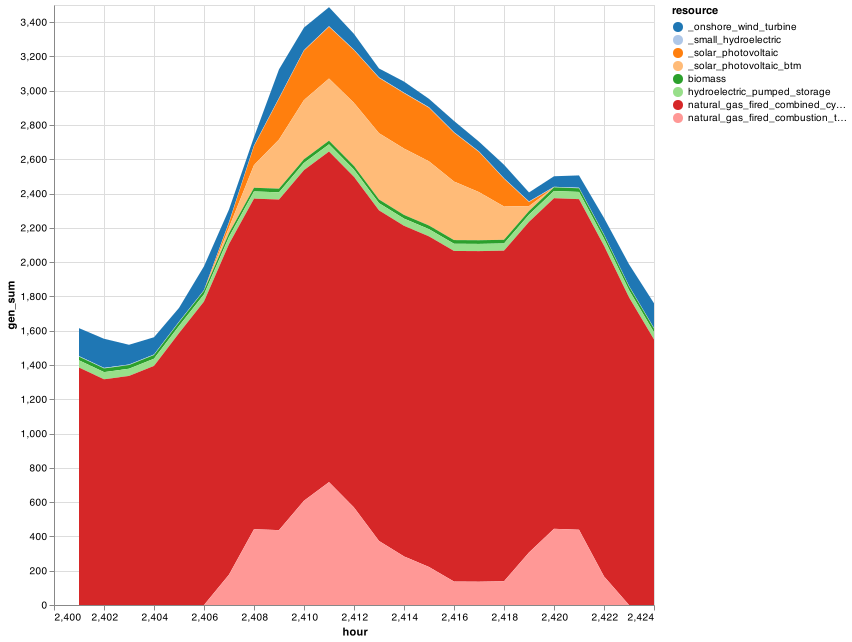

In [37]:
solution = economic_dispatch_multi_time(gen_df, loads_multi, gen_variable_multi);

sol_gen = innerjoin(solution.solution, 
                    gen_df[!, [:r_id, :resource]], 
                    on = :r_id)
sol_gen = combine(groupby(sol_gen, [:resource, :hour]), 
            :gen => sum)
sol_gen_btm = sol_gen
sol_gen_btm[sol_gen_btm.resource .== "solar_photovoltaic", :resource] .= "_solar_photovoltaic"
sol_gen_btm[sol_gen_btm.resource .== "onshore_wind_turbine", :resource] .= "_onshore_wind_turbine"
sol_gen_btm[sol_gen_btm.resource .== "small_hydroelectric", :resource] .= "_small_hydroelectric"

btm = DataFrame(resource = repeat(["_solar_photovoltaic_btm"]; outer=length(T_period)), 
    hour = T_period,
    gen_sum = gen_variable_multi[gen_variable_multi.gen_full .== "wec_sdge_solar_photovoltaic_1.0",:cf] * 600)
append!(sol_gen_btm, btm)

# Reorder resources
sort!(sol_gen_btm, [:hour, :resource])

sol_gen_btm |>
@vlplot(:area, 
    x=:hour, y={:gen_sum, stack=:zero}, 
    color={"resource:n", scale={scheme="category20"}},
    width=600,height=600)

In [31]:
# Save this stacked dispatch plot to file if you want to
sol_gen_btm |> FileIO.save("results/ED_moderate.png")

All errors:
ArgumentError: Package ImageIO [82e4d734-157c-48bb-816b-45c225c6df19] is required but does not seem to be installed:
 - Run `Pkg.instantiate()` to install all recorded dependencies.

ArgumentError: Package QuartzImageIO [dca85d43-d64c-5e67-8c65-017450d5d020] is required but does not seem to be installed:
 - Run `Pkg.instantiate()` to install all recorded dependencies.

ArgumentError: Package ImageMagick [6218d12a-5da1-5696-b52f-db25d2ecc6d1] is required but does not seem to be installed:
 - Run `Pkg.instantiate()` to install all recorded dependencies.

ArgumentError: Argument does not support conversion to png.


Errors encountered while save File{DataFormat{:PNG}, String}("results/ED_moderate.png").

Fatal error:


LoadError: ArgumentError: Package ImageIO [82e4d734-157c-48bb-816b-45c225c6df19] is required but does not seem to be installed:
 - Run `Pkg.instantiate()` to install all recorded dependencies.

Stacktrace:
  [1] [0m[1m_require[22m[0m[1m([22m[90mpkg[39m::[0mBase.PkgId[0m[1m)[22m
[90m    @ [39m[90mBase[39m [90m./[39m[90m[4mloading.jl:1306[24m[39m
  [2] [0m[1m_require_prelocked[22m[0m[1m([22m[90muuidkey[39m::[0mBase.PkgId[0m[1m)[22m
[90m    @ [39m[90mBase[39m [90m./[39m[90m[4mloading.jl:1200[24m[39m
  [3] [0m[1mmacro expansion[22m
[90m    @ [39m[90m./[39m[90m[4mlock.jl:223[24m[39m[90m [inlined][39m
  [4] [0m[1mrequire[22m[0m[1m([22m[90muuidkey[39m::[0mBase.PkgId[0m[1m)[22m
[90m    @ [39m[90mBase[39m [90m./[39m[90m[4mloading.jl:1195[24m[39m
  [5] [0m[1m#34[22m
[90m    @ [39m[90m~/.julia/packages/FileIO/DtNtF/src/[39m[90m[4mloadsave.jl:203[24m[39m[90m [inlined][39m
  [6] [0m[1mlock[22m[0m[1m([22m[90mf[39m::[0mFileIO.var"#34#35"[90m{Base.PkgId}[39m, [90ml[39m::[0mReentrantLock[0m[1m)[22m
[90m    @ [39m[90mBase[39m [90m./[39m[90m[4mlock.jl:185[24m[39m
  [7] [0m[1maction[22m[0m[1m([22m[90mcall[39m::[0mSymbol, [90mlibraries[39m::[0mVector[90m{Union{Base.PkgId, Module}}[39m, [90mfile[39m::[0mFileIO.Formatted, [90margs[39m::[0mDataFrame; [90moptions[39m::[0mBase.Pairs[90m{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}[39m[0m[1m)[22m
[90m    @ [39m[35mFileIO[39m [90m~/.julia/packages/FileIO/DtNtF/src/[39m[90m[4mloadsave.jl:203[24m[39m
  [8] [0m[1maction[22m
[90m    @ [39m[90m~/.julia/packages/FileIO/DtNtF/src/[39m[90m[4mloadsave.jl:196[24m[39m[90m [inlined][39m
  [9] [0m[1maction[22m[0m[1m([22m[90mcall[39m::[0mSymbol, [90mlibraries[39m::[0mVector[90m{Union{Base.PkgId, Module}}[39m, [90msym[39m::[0mSymbol, [90mfile[39m::[0mString, [90margs[39m::[0mDataFrame; [90moptions[39m::[0mBase.Pairs[90m{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}[39m[0m[1m)[22m
[90m    @ [39m[35mFileIO[39m [90m~/.julia/packages/FileIO/DtNtF/src/[39m[90m[4mloadsave.jl:185[24m[39m
 [10] [0m[1maction[22m
[90m    @ [39m[90m~/.julia/packages/FileIO/DtNtF/src/[39m[90m[4mloadsave.jl:185[24m[39m[90m [inlined][39m
 [11] [0m[1m#27[22m
[90m    @ [39m[90m~/.julia/packages/FileIO/DtNtF/src/[39m[90m[4mloadsave.jl:149[24m[39m[90m [inlined][39m
 [12] [0m[1m|>[22m[0m[1m([22m[90mx[39m::[0mDataFrame, [90mf[39m::[0mFileIO.var"#27#28"[90m{Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, String, Vector{Union{Base.PkgId, Module}}, Symbol}[39m[0m[1m)[22m
[90m    @ [39m[90mBase[39m [90m./[39m[90m[4moperators.jl:911[24m[39m
 [13] top-level scope
[90m    @ [39m[90m[4mIn[31]:2[24m[39m

### 5. Run sensitivity on solar capacity

Let's now examine what happens if we increase utility solar capacity from the current 500MW up to 3,500MW.

The large reduction in net load during the day and the loss of solar (orange) in the late afternoon timed with the rise in the evening peak is sometimes called the **"duck curve"** because of their passing resemblance to a duck's belly and head. Squint at it and then examine this (https://www.energy.gov/eere/articles/confronting-duck-curve-how-address-over-generation-solar-energy):

<img src="https://www.energy.gov/sites/prod/files/styles/borealis_photo_gallery_large_respondmedium/public/CAISO_DuckCurve_720_469_80.jpg?itok=99uYAxGo" style="width: 450px; height: auto" align="left">

Presolving model
208 rows, 589 cols, 957 nonzeros
116 rows, 528 cols, 712 nonzeros
116 rows, 528 cols, 712 nonzeros
Presolve : Reductions: rows 116(-1658); columns 528(-72); elements 712(-2788)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 24(54962.6) 0s
         35     8.0426374437e+05 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 35
Objective value     :  8.0426374437e+05
HiGHS run time      :          0.00


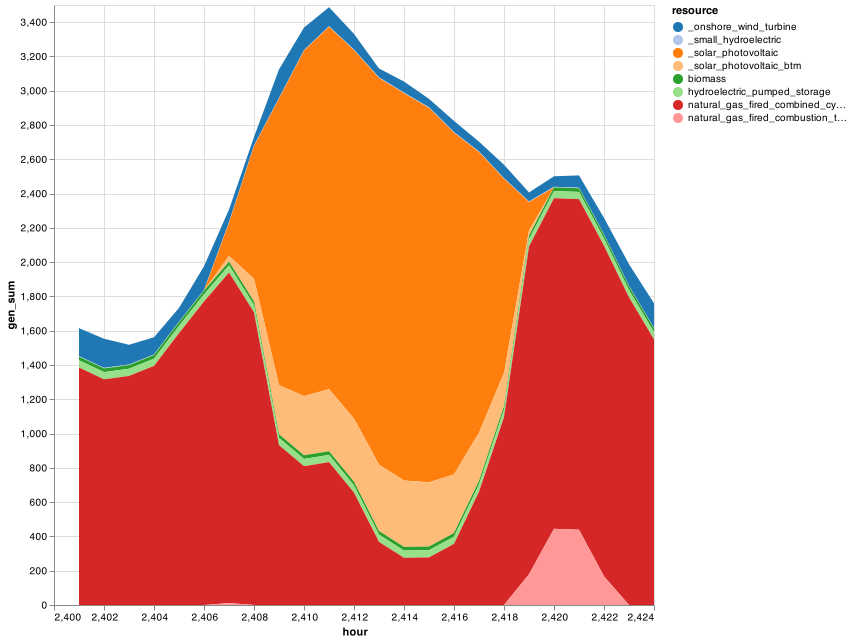

In [38]:
# Increase solar photovoltaic capacity
gen_df_sens = copy(gen_df)
gen_df_sens[gen_df_sens.resource .== "solar_photovoltaic",
    :existing_cap_mw] .= 3500

solution = economic_dispatch_multi_time(gen_df_sens, loads_multi, gen_variable_multi);

sol_gen = innerjoin(solution.solution, 
                    gen_df[!, [:r_id, :resource]], 
                    on = :r_id)

sol_gen = combine(groupby(sol_gen, [:resource, :hour]), 
            :gen => sum)
sol_gen_btm = copy(sol_gen)
sol_gen_btm[sol_gen_btm.resource .== "solar_photovoltaic", :resource] .= "_solar_photovoltaic"
sol_gen_btm[sol_gen_btm.resource .== "onshore_wind_turbine", :resource] .= "_onshore_wind_turbine"
sol_gen_btm[sol_gen_btm.resource .== "small_hydroelectric", :resource] .= "_small_hydroelectric"

btm = DataFrame(resource = repeat(["_solar_photovoltaic_btm"]; outer=length(T_period)), 
    hour = T_period,
    gen_sum = gen_variable_multi[gen_variable_multi.gen_full .== "wec_sdge_solar_photovoltaic_1.0",:cf] * 600)
append!(sol_gen_btm, btm)

# Reorder resources
sort!(sol_gen_btm, [:hour, :resource])

# Plot and save the resulting generation figure
p = sol_gen_btm |>
@vlplot(:area, 
    x=:hour, y={:gen_sum, stack=:zero}, 
    color={"resource:n", scale={scheme="category20"}},
    width=600,height=600)
save("results/sol_gen_btm.png",p)
p

You may notice that the model still uses combustion turbines (light pink above) during hours when there is sufficient capacity of combined cycle plants, which are more efficient. This is because of ramp limits, which we will examine now.

All constraints (in a linear program) have a **"marginal value"** (also known as "shadow price" or "dual value") which is how much the objective would change if the right-hand-side (RHS) of the constraint were increased by one unit. Let's examine the marginal value/dual of the ramp up constraint for the combined cycle plants using the values from the new equation we added to `economic_dispatch_multi_time` (line 72).

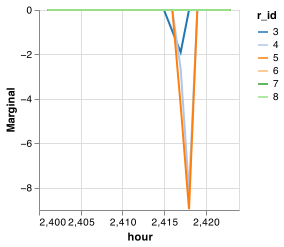

In [39]:
marg_gen = innerjoin(solution.marginals, 
                    gen_df[!, [:r_id, :resource]], 
                    on = :r_id)
marg_gen[marg_gen.resource .== "natural_gas_fired_combined_cycle",:] |>
@vlplot(:line, 
    x=:hour, y={:gen, title="Marginal"}, 
    color={"r_id:n", scale={scheme="category20"}})


Thus, during the ramp hours, the marginal value becomes negative&mdash;in this case, reaching ~ -9 for the combined cycle plant with `r_id=5`. This is the interpretation:

**If the RHS of the RampUp constraint for `r_id=5` combined cycle plant were increased by 1 unit, the problem objective would reduce by about 9.** 

The precise value of the largest magnitude ramp marginal is:

In [40]:
marg_gen[argmin(marg_gen.gen),:]

,r_id,hour,gen,resource
,Int64?,Int64,Float64,String?
430,5,2418,-8.9672,natural_gas_fired_combined_cycle


**Why is this the case?** Due to the ramp constraint, we have to substitute some generation from `r_id=5` with a more expensive unit, in this case the more flexible `r_id=9` combustion turbine. 

We can, in fact, recover this marginal value by re-examining the variable costs of these generators at the top of the notebook:

In [41]:
varcost_comp = supply_curve[in.(supply_curve.r_id,Ref([5,9])),[:r_id,:varcost]]
varcost_comp

,r_id,varcost
,Int64?,Float64
1,5,29.3061
2,9,38.2733


If our guess is true, the difference between these should be our marginal value, and voila:

In [42]:
varcost_comp[2,2] - varcost_comp[1,2]

8.967199999999998

Also notice that the marginals are zero for most of the day. Recalling from Notebook 1 our discussion on "binding" constraints, this is because the RampUp constraint is **not binding** during these hours. Alternatively, changing the RHS of the RampUp constraint does not affect the problem objective.